### 0. Motivation
Here we'll work with a toy model of alchemy!

Given two unnormalized probability distributions, our goal is to estimate the ratio of their normalizing constants. This comes up in, for example, computing drug binding affinities. The binding affinity is related to the relative free energies of the bound vs. unbound states, which is related to the log of the ratio of the normalizing constants.

Each system is described by a probability distribution over available states $x$. This probability distribution is induced by an energy function that assigns each state a number. Higher energy states are much less probable than lower energy states, and their relative probabilities are given by the Boltzmann distribution.

### 1. Defining the systems


Let's set up a potential function $U_\text{target}(x;\lambda) = U_\text{initial}(x) + \lambda U_\text{alchemy}(x)$ in terms of an initial potential $U_\text{initial}$ and an alchemical perturbation $U_\text{alchemy}$ that transforms the initial potential energy surface into the target.

We can now easly create a family of intermediate potentials by varying $\lambda$ between 0 and 1.

Our goal will be to estimate $$\frac{\mathcal{Z}_T}{ \mathcal{Z}_1}$$
where $$\mathcal{Z}_T = \int e^{- U_\text{target}(x) / T} dx \equiv \int p_{\lambda=1}(x) dx$$ and $$\mathcal{Z}_1 = \int e^{- U_\text{initial}(x) / T} dx \equiv \int p_{\lambda=0}(x) dx$$.

### 2. Annealed importance sampling
[This largely follows the review in section 3 of: [Sandwiching the marginal likelihood using bidirectional Monte Carlo (Grosse, Ghahramani, and Adams, 2015)](http://arxiv.org/abs/1511.02543)]
$\newcommand{\x}{\mathbf{x}}
\newcommand{\Z}{\mathcal{Z}}$

**Goal:**

We want to estimate the normalizing constant $\Z = \int p_T(\x) d\x$ of a complicated distribution $p_T$ we know only up to a normalizing constant.

**A basic strategy:**

Importance sampling, i.e. draw each sample from an easy distribution $\x^{(k)} \sim p_1$, then reweight by $w^{(k)}\equiv p_T(\x)/p_1(\x)$. After drawing $K$ such samples, we can estimate the normalizing constant as $$\hat{\Z} = \frac{1}{K} \sum_{k=1}^K w^{(k)} \equiv  \frac{1}{K} \sum_{k=1}^K \frac{p_T(\x^{(k)} )}{p_1(\x^{(k)})}$$.

**Problem:**

Although importance sampling will eventually work as $K \to \infty$ as long as the support of $p_1$ contains the support of $p_T$, this will be extremely inefficient if $p_1$ and $p_T$ are very different.

**Actual strategy:**

Instead of doing the importance reweighting computation in one step, gradually convert a sample from the simpler distribution $p_1$ to the target distribution $p_T$ by introducing a series of intermediate distributions $p_1,p_2,\dots,p_{T}$, chosen so that no $p_t$ and $p_{t+1}$ are dramatically different. We can then estimate the overall importance weight as a product of more reasonable ratios.

**Inputs:**
- Desired number of samples $K$
- An initial distribution $p_1(\x)$ for which we can:
    - Draw samples: $\x_s \sim p_1(\x)$
    - Evaluate the normalizing constant: $\Z_1$
- A target (unnormalized) distribution function: $f_T(\x)$
- A sequence of annealing distribution functions $f_1,\dots,f_T$. These can be almost arbitrary, but here are some options:
    - We can construct these generically by taking **geometric averages** of the initial and target distributions: $f_t(\x_) = f_1(\x)^{1-\beta_t}f_T(\x)^{\beta_t}$
    - In the case of a target distribution $f_T(\x) \propto \exp(-U(\x) \beta)$ (where $\beta$ is the inverse temperature), we could also construct the annealing distributions as Boltzmann distributions at **decreasing temperatures.**
    - In the case of a target distribution defined in terms of a force field, we could also construct the annealing distributions by starting from an **alchemically softened** form of the potential and gradually turning on various parts of the potential.
    - Could use "boost potentials" from accelerated MD (http://www.ks.uiuc.edu/Research/namd/2.9/ug/node63.html)
    - If we have some way to make dimension-matching proposals, we might use **coarse-grained potentials** as intermediates.
- A sequence of Markov transition kernels $\mathcal{T}_1,\dots,\mathcal{T}_T$, where each $\mathcal{T}_t$ leaves its corresponding distribution $p_t$ invariant. These can be almost arbitrary, but here are some options:
    - Random-walk Metropolis
    - Symplectic integrators of Hamiltonian dynamics
    - NCMC

**Outputs:**
- A collection of weights $w^{(k)}$, from which we can compute an unbiased estimate of the normalizing constant of $f_t$ by $\hat{\Z}=\sum_{k=1}^K w^{(k)} / K$

**Algorithm:**

for $k=1$ to $K\\$:
1. $\x_1 \leftarrow$ sample from $p_1(\x)$
2. $w^{(k)} \leftarrow \Z_1$
3. for $t=2$ to $T$:
    - $w^{(k)} \leftarrow w^{(k)} \frac{f_t(\x_{t-1})}{f_{t-1}(\x_{t-1})}$
    - $\x_t \leftarrow $ sample from $\mathcal{T}_t(\x | \x_{t-1})$

### 3. Bidirectional Monte Carlo

$\newcommand{\x}{\mathbf{x}}
\newcommand{\Z}{\mathcal{Z}}$
- Note that AIS can be interpreted as an instance of simple importance sampling over an extended state space:
    - The full set of states visited by the algorithm ($x_1,\dots,x_{T-1}$) has a joint distribution:
    $$ \newcommand{\T}{\mathcal{T}}
    q_{\text{forward}} (x_1,\dots,x_{T-1}) = p_1(x_1) \T_2 (x_2 | x_1) \dots \T_{T-1} (x_{T-1} | x_{T-2})
    $$
        - Where $x_1$ is an exact sample from $p_1$
    - We could postulate a reverse chain:
    $$q_{\text{reverse}} (x_1,\dots,x_{T-1}) = p_T(x_{T-1}) \T_{T-1} (x_{T-2} | x_{T-1}) \dots \T_2 (x_1 | x_2)
    $$
        - Where $x_{T-1}$ is an exact sample from $p_T$
    - Note that:
    $$\frac{q_{\text{back}}}{q_{\text{forward}}} = \frac{\Z_1}{\Z_T}w$$
    where $w$ is the weight computed in AIS, and $\mathbb{E}[w] = \Z_T / \Z_1$

- We would like to define consistent stochastic upper and lower bounds on log marginal likelihood for simulated data
- Stochastic lower bounds can be computed using existing methods
- Stochastic upper bounds can be obtained from exact samples from the posterior distribution

#### 3.1. Obtaining stochastic lower bounds
- AIS and SIS are unbiased estimators $\newcommand{\Z}{\mathcal{Z}} \mathbb{E}[\hat{\Z}] = \Z$
    - Since $\Z$ can vary over many orders of magnitude, we may try to estimate $\log \Z$ instead of $\Z$
    - Unbiased estimators of $\Z$ can be biased estimators of $\log \Z$
    - Unbiased estimators of $\Z$ are stochastic lower bounds on $\log \Z$ since (1) they are unlikely to over-estimate $\log \Z$ and (2) they cannot overestimate $\log Z$ in expectation ($\mathbb{E}[\log \hat{\Z}] \leq \log \Z$).
        - Because they are nonnegative estimators of a nonnegative quantity, they are extremely unlikely to overestimate $\log \Z$ by more than a few nats:
$$\Pr(\log \hat{\Z} \geq \log \mathcal{Z} + a) \leq \exp(-a)$$

            - Proof:
                1. Markov's inequality states that $\Pr(X \geq a) \leq \frac{\mathbb{E}[X]}{a}$ for $a>0$ and $X$ a nonnegative r.v.
                2. Since these are unbiased estimators, $\mathbb{E}[\hat{\Z}] = \Z$, so we have that $\Pr(\hat{\Z} \geq a) \leq \frac{\Z}{a}$.
                3. By replacing $a$ with $a\Z$, we have $\Pr(\hat{\Z} \geq a \Z) \leq 1/a$. (Note: in the paper, it's written as $<$, but I think it should be $\leq$.)
                
                5. By taking the log, we have that:
            $$\Pr(\log \hat{\Z} \geq \log \mathcal{Z} + a) \leq \exp(-a)$$
        - There's also Jensen's inequality:
        $$ \mathbb{E}[\log \hat{\Z}] \leq \log \mathbb{E}[\hat{\Z}] = \log \Z$$

#### 3.2. Obtaining stochastic upper bounds
- It's harder to get good upper bounds than to get good lower bounds:
    - Lower bound: point to regions of high probability mass
    - Upper bound: demonstrate absence of any additional probability mass
- Applying the arguments from 4.1, unbiased estimators of $\frac{1}{\Z}$ are stochastic upper bounds on $\log \Z$.
    - The harmonic mean estimator is an unbiased estimator of $\frac{1}{\Z}$, but has two problems:
        - **Need exact samples**. If approximate posterior samples are used, the estimator is not a stochastic upper bound.
        - **Loose bound**. Even if exact samples are used, the bound is very bad.
- We can get **exact posterior samples for simulated data,** since we know the parameters used to generate the data. Note that there are two ways to sample the joint distribution $p(\theta,y)$:
    - We can sample $\theta \sim p(\theta)$ then $y \sim p(y|\theta)$
    - We can sample $y \sim p(y)$ then $\theta \sim p(\theta|y)$
    - Thus, for a simulated dataset $y \sim p(y|\theta)$, we have an exact posterior sample-- the $\theta$ used to generate the dataset.
- We can get a **tighter bound** if we do HME but with multiple intermediate distributions instead of simple importance sampling. We'll do this two ways: **reverse AIS** and **sequential HME**.

##### 3.2.1. Reverse AIS
- We can interpret AIS as simple importance sampling over an extended state space (where each state is a sequence of $x$'s), where the proposal and target distributions are foreward and backward annealing chains.
- In the case of simulated data, we can sample the reverse chain with an exact sample from $p_T(x)$.
- The importance weights for the forward chain using the backward chain as a proposal are then:
 $$\frac{q_{\text{forward}}}{q_{\text{back}}} = \frac{\Z_T}{\Z_1}w$$
 where
 $$ w \equiv \frac{f_{T-1}(x_{T-1})}{f_T(x_{T-1})} \cdots \frac{f_1(x_1)}{f_2(x_1)}$$
 
- We then obtain the following estimate of $\Z$:
$$\hat{\Z} = \frac{K}{\sum_{k=1}^K w^{(k)}}$$

In [2]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
%matplotlib inline

In [3]:
# initial system
def harmonic_osc_potential(x):
    ''' quadratic energy well '''
    return np.sum(x**2)

# alchemical perturbation
def egg_crate_potential(x,freq=20):
    ''' bumpy potential '''
    return np.sum(np.sin(freq*x))

# target system
def total_potential(x,lam=0):
    ''' bumpy energy well at lam=1, smooth well at lam=0 '''
    return harmonic_osc_potential(x)+ lam* egg_crate_potential(x)

# reduced potential for the ensemble of interest
def reduced_potential(x,lam=0.0,temp=1.0):
    ''' assuming a heat bath '''
    return total_potential(x,lam) / temp

# probability of a state
def boltzmann_weight(x,lam=0.0,temp=1.0):
    ''' at equilibrium, the log probability (density) of a state is proportional to 
    minus its reduced potential '''
    return np.exp(-reduced_potential(x,lam,temp))

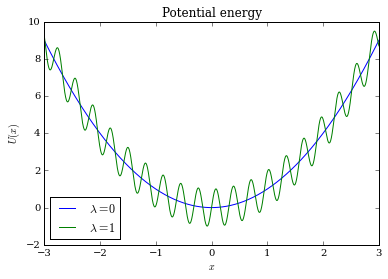

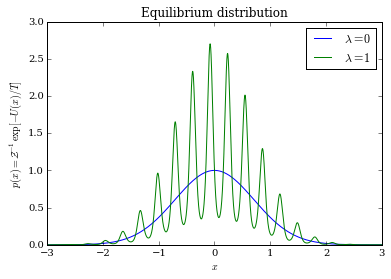

In [4]:
x = np.linspace(-3,3,10000)
temp=1.0

# potential
u_0 = np.array([total_potential(x_,lam=0) for x_ in x])
u_1 = np.array([total_potential(x_,lam=1) for x_ in x])

plt.plot(x,u_0,label=r'$\lambda=0$')
plt.plot(x,u_1,label=r'$\lambda=1$')
plt.xlabel(r'$x$')
plt.ylabel(r'$U(x)$')
plt.title('Potential energy')
plt.legend(loc='best')

plt.figure()

# boltzmann distribution
p_0 = np.array([boltzmann_weight(x_,lam=0) for x_ in x])
p_1 = np.array([boltzmann_weight(x_,lam=1) for x_ in x])
plt.plot(x,p_0,label=r'$\lambda=0$')
plt.plot(x,p_1,label=r'$\lambda=1$')
plt.xlabel(r'$x$')
plt.ylabel(r'$p(x) = \mathcal{Z}^{-1} \exp[-U(x)/T]$')
plt.title('Equilibrium distribution')
plt.legend(loc='best')

In [5]:
# let's collect a ton of approximate samples using MCMC,
# so we can pretend we have exact samples later

# this is analogous to the situation if we can collect approximate
# samples at the desired end states using MD or MCMC
import emcee
n_walkers=10
n_samples=50000
burn_in = (n_samples*n_walkers) / 3

log_p0 = lambda x:-reduced_potential(x,lam=0,temp=temp)
sampler_0 = emcee.EnsembleSampler(n_walkers,1,log_p0)
_ = sampler_0.run_mcmc(npr.randn(n_walkers,1),n_samples)
samples_0 = sampler_0.flatchain[burn_in:]

def sample_from_initial():
    return samples_0[npr.randint(len(samples_0))]

log_p1 = lambda x:-reduced_potential(x,lam=1,temp=temp)

sampler_1 = emcee.EnsembleSampler(n_walkers,1,log_p1)
_ = sampler_1.run_mcmc(npr.randn(n_walkers,1),n_samples)
samples_1 = sampler_1.flatchain[burn_in:]

def sample_from_target():
    return samples_1[npr.randint(len(samples_1))]

In [6]:
# how many samples do we have
len(samples_1)

333334

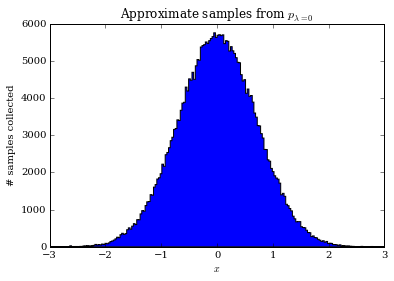

In [7]:
plt.hist(samples_0,range=(-3,3),bins=200,histtype='stepfilled');
plt.xlabel(r'$x$')
plt.ylabel('# samples collected')
plt.title(r'Approximate samples from $p_{\lambda=0}$')

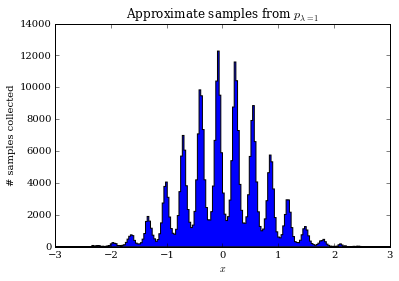

In [8]:
plt.hist(samples_1,range=(-3,3),bins=200,histtype='stepfilled');
plt.xlabel(r'$x$')
plt.ylabel('# samples collected')
plt.title(r'Approximate samples from $p_{\lambda=1}$')

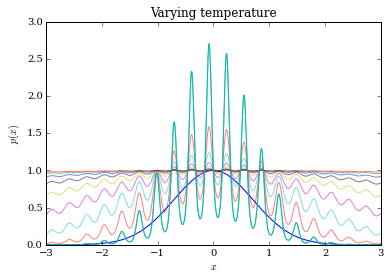

In [9]:
# changing temperature
temp=1.0
p_0 = np.exp(-u_0/temp)
plt.plot(x,p_0)

for temp_ in np.logspace(0,3,10)[:-1]*temp:
    p_t = np.exp(-u_1/temp_)
    plt.plot(x,p_t,alpha=0.5)

plt.plot(x,p_1)

plt.xlabel(r'$x$')
plt.ylabel(r'$p(x)$')
plt.title('Varying temperature')

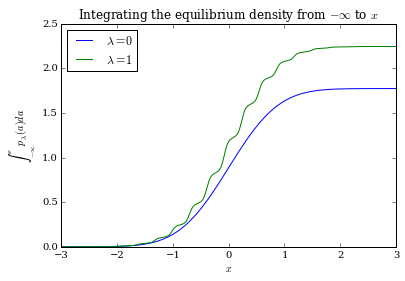

In [10]:
plt.plot(x,np.cumsum(p_0)*(x[1]-x[0]),label=r'$\lambda=0$')
plt.plot(x,np.cumsum(p_1)*(x[1]-x[0]),label=r'$\lambda=1$')
plt.xlabel(r'$x$')
plt.ylabel(r'$\int_{-\infty}^x p_\lambda(a) da$')
plt.title(r'Integrating the equilibrium density from $-\infty$ to $x$')
plt.legend(loc='best')

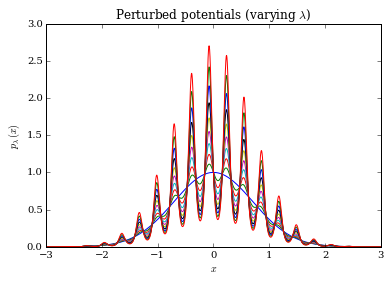

In [12]:
# alchemical intermediates
temp=1.0

for lam in np.linspace(0,1.0,10):
    u_1am = np.array([total_potential(x_,lam=lam) for x_ in x])
    p_1am = np.exp(-u_1am/temp)
    plt.plot(x,p_1am)

plt.xlabel(r'$x$')
plt.ylabel(r'$p_\lambda(x)$')
plt.title(r'Perturbed potentials (varying $\lambda$)')

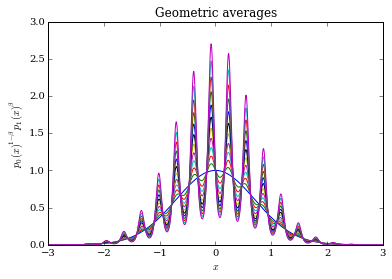

In [13]:
# show geometric averages

from annealing_distributions import GeometricMean

num_intermediates = 1
betas = np.linspace(0,1,12)
annealing_distributions = [p_0**(1-beta) * p_1**beta for beta in betas]
for dist in annealing_distributions:
    plt.plot(x,dist)
plt.title('Geometric averages')
plt.xlabel(r'$x$')
plt.ylabel(r'$p_0(x)^{1-\beta}p_1(x)^{\beta}$')

In [14]:
# also show: (1) boost potential? or (2) Neal's optimal interpolants?

In [15]:
# numerically integrate using a deterministic (trapezoidal) quadrature rule
x = np.linspace(-10,10,10000)
Z_0 = np.trapz(p_0,x)
Z_1 = np.trapz(p_1,x)
Z_0,Z_1

(5.9080489882486864, 7.4799767744791987)

In [16]:
# the ratio of partition functions
Z_ratio = Z_1/Z_0
Z_ratio,np.log(Z_ratio)

(1.2660654624491319, 0.23591403048084772)

### 4. Choose annealing distributions for AIS

In [17]:
# let's go with perturbed hamiltonians for now

protocol = np.linspace(0,1,10)

class AlchemicalIntermediate():
    def __init__(self,lam=0.0):
        self.lam=lam
    def __call__(self,x):
        return boltzmann_weight(x,lam=self.lam)

annealing_distributions = [AlchemicalIntermediate(lam) for lam in protocol]

### 5. Run forward and reverse AIS
To get stochastic upper and lower bounds on $\log ( \mathcal{Z}_T / \mathcal{Z}_1)$.

In [18]:
%%time
from bidirectional_mc import bidirectional_ais

from transition_kernels import gaussian_random_walk
transition_kernels = [gaussian_random_walk]*len(annealing_distributions)

npr.seed(1)
ub,lb,forward_results,reverse_results \
            = bidirectional_ais(sample_from_initial,
                              sample_from_target,
                              transition_kernels,
                              annealing_distributions,
                              n_samples=10000)

CPU times: user 34.5 s, sys: 92.9 ms, total: 34.6 s
Wall time: 34.6 s


### 5. Plot bounds as a function of # samples collected

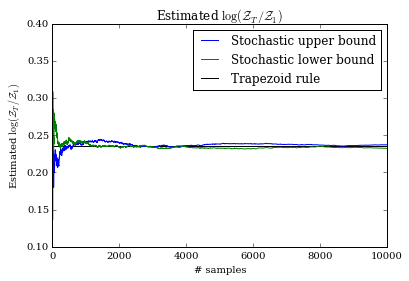

In [20]:
plt.plot(ub,label='Stochastic upper bound')
plt.plot(lb,label='Stochastic lower bound')
plt.hlines(np.log(Z_ratio),0,len(ub),label='Trapezoid rule')
plt.xlabel('# samples')
plt.ylabel(r'Estimated $\log ( \mathcal{Z}_T / \mathcal{Z}_1)$')
plt.title(r'Estimated $\log ( \mathcal{Z}_T / \mathcal{Z}_1)$')
plt.legend(loc='best')
#plt.ylim(0.21,0.25)

### 5.1. Plot gap between upper and lower bounds

0.00464133481273


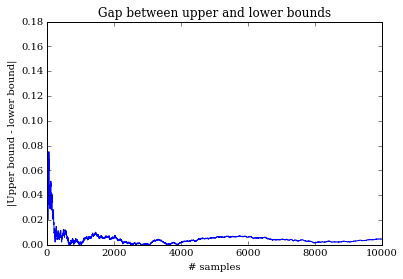

In [21]:
plt.plot(np.abs(ub-lb))
print(np.abs(ub-lb)[-1])
plt.xlabel('# samples')
plt.ylabel('|Upper bound - lower bound|')
plt.title('Gap between upper and lower bounds')

### 6. Plot intermediate $\mathcal{Z}_{t}/\mathcal{Z}_{t-1}$'s

In [22]:
z_hat_f,xs_f,weights_f,ratios_f=forward_results
z_hat_r,xs_r,weights_r,ratios_r=reverse_results

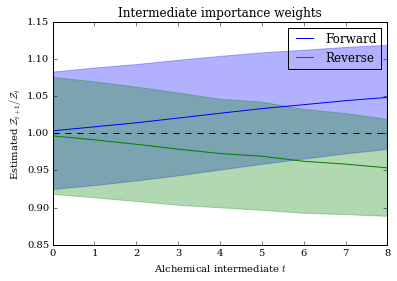

In [23]:
mean_f = ratios_f.mean(0)
err_f = ratios_f.std(0)
plt.plot(mean_f,color='blue',label='Forward');
plt.fill_between(range(len(mean_f)),mean_f-err_f,mean_f+err_f,alpha=0.3,color='blue')
plt.hlines(1.0,0,len(mean_f)-1,linestyle='--')
#plt.figure()
mean_r = ratios_r.mean(0)[::-1]
err_r = ratios_r.std(0)[::-1]
plt.plot(mean_r,color='green',label='Reverse');
plt.fill_between(range(len(mean_r)),mean_r-err_r,mean_r+err_r,alpha=0.3,color='green')
plt.legend(loc='best')
plt.xlabel(r'Alchemical intermediate $t$')
plt.ylabel('Estimated $\mathcal{Z}_{t+1}/\mathcal{Z}_{t}$')
plt.title('Intermediate importance weights')

### 7. Now let's try a toy chemical system

Instead of defining a simple 1D potential as above, let's use a potential energy function given by a real forcefield.

Here $\vec{x}$ will be the positions of all 22 atoms in alanine dipeptide. The target potential $U_\text{target}(\vec{x})$ will be the full potential energy function of $\vec{x}$ (including terms for bonds, sterics, electrostatics, angles, and torsions). The initial potential $U_\text{initial}(\vec{x})$ will be a simpler potential energy function, where the terms for steric and electrostatic interactions will turned off. A family of alchemical intermediates will again be constructed by tuning a parameter $\lambda$ between 0 and 1.

In [24]:
from openmmtools import testsystems
from alchemy import AbsoluteAlchemicalFactory

In [25]:
test_systems = dict()

name='alanine dipeptide in vacuum with annihilated sterics'
ala = {
    'test' : testsystems.AlanineDipeptideVacuum(),
    'factory_args' : {'ligand_atoms' : range(0,22), 'receptor_atoms' : range(22,22),
    'annihilate_sterics' : True, 'annihilate_electrostatics' : True }}

In [26]:
system = ala['test']
ref_sys,pos = system.system,system.positions

factory = AbsoluteAlchemicalFactory(ref_sys,**ala['factory_args'])

protocol = factory.defaultSolventProtocolImplicit()[::-1]

systems = factory.createPerturbedSystems(protocol)

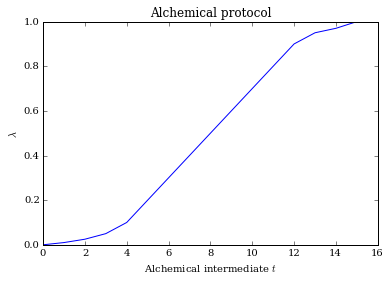

In [27]:
plt.xlabel(r'Alchemical intermediate $t$')
plt.ylabel(r'$\lambda$')
plt.title('Alchemical protocol')
plt.plot([p['lambda_sterics'] for p in protocol],label=r'$\lambda$ sterics')
#the plot for lambda electrostatics is the same

In [28]:
%%time

from time import time
t = time()
from simtk import openmm
from simtk.unit import *

n_samples = 100
n_steps = 500

temperature = 300.0 * kelvin
collision_rate = 5.0 / picoseconds
timestep = 2.0 * femtoseconds
kB = BOLTZMANN_CONSTANT_kB * AVOGADRO_CONSTANT_NA
kT = (kB * temperature)

new_int = lambda:openmm.VerletIntegrator(timestep)

integrator_0 = new_int()
integrator_1 = new_int()

# collect roughly equilibrated samples at the start and end points
context_0 = openmm.Context(systems[0], integrator_0)
context_0.setPositions(pos)

context_1 = openmm.Context(systems[-1], integrator_1)
context_1.setPositions(pos)

pos_samples_0 = []
energies_0 = []

pos_samples_1 = []
energies_1 = []

for i in range(n_samples):
    if i % 10 == 0:
        print(i,time() - t)
    integrator_0.step(n_steps)
    state = context_0.getState(getEnergy=True, getPositions=True)
    potential = state.getPotentialEnergy()
    pos = state.getPositions()
    pos_samples_0.append(pos)
    energies_0.append(potential)
    #context_0.setVelocitiesToTemperature(300)
    
    integrator_1.step(n_steps)
    state = context_1.getState(getEnergy=True, getPositions=True)
    potential = state.getPotentialEnergy()
    pos = state.getPositions()
    pos_samples_1.append(pos)
    energies_1.append(potential)
    #context_1.setVelocitiesToTemperature(300)

print(time() - t)

(0, 1.350464105606079)
(10, 4.917132139205933)
(20, 8.271116018295288)
(30, 11.89766812324524)
(40, 15.712298154830933)
(50, 19.612114191055298)
(60, 22.861194133758545)
(70, 26.465635061264038)
(80, 29.881081104278564)
(90, 33.11797499656677)
36.3534190655
CPU times: user 8.51 s, sys: 8.77 s, total: 17.3 s
Wall time: 36.4 s


In [29]:
protocol[0],protocol[-1]

({'lambda_angles': 1.0,
  'lambda_bonds': 1.0,
  'lambda_electrostatics': 0.0,
  'lambda_restraints': 0.0,
  'lambda_sterics': 0.0,
  'lambda_torsions': 1.0},
 {'lambda_angles': 1.0,
  'lambda_bonds': 1.0,
  'lambda_electrostatics': 1.0,
  'lambda_restraints': 0.0,
  'lambda_sterics': 1.0,
  'lambda_torsions': 1.0})

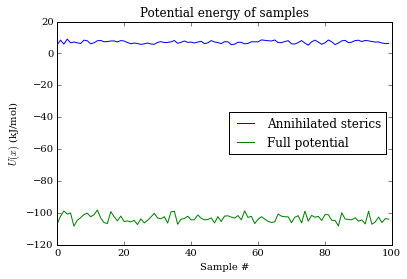

In [30]:
plt.title('Potential energy of samples')
plt.plot([e.value_in_unit(kilojoule / mole) for e in energies_0],label='Annihilated sterics')
plt.plot([e.value_in_unit(kilojoule / mole) for e in energies_1],label='Full potential')
plt.legend(loc='best')
plt.xlabel('Sample #')
plt.ylabel(r'$U(x)$ (kJ/mol)')

In [31]:
array_pos_0 = np.vstack([np.array(pos.value_in_unit(nanometer)).flatten() for pos in pos_samples_0])

In [32]:
array_pos_1 = np.vstack([np.array(pos.value_in_unit(nanometer)).flatten() for pos in pos_samples_1])

In [33]:
def sample_from_initial():
    return array_pos_0[npr.randint(len(array_pos_0))]

def sample_from_target():
    return array_pos_1[npr.randint(len(array_pos_1))]

In [34]:
n_atoms = array_pos_0.shape[1]/3
n_atoms

22

In [35]:
temp = temperature.value_in_unit(kelvin)

In [36]:
%%time
integrator_0.step(1000)

CPU times: user 16.3 ms, sys: 4.49 ms, total: 20.8 ms
Wall time: 14.2 ms


### 8. Define each annealing distribution and its Markov transition kernel

In [37]:
contexts = [openmm.Context(sys,new_int()) for sys in systems]

class MarkovKernel():
    ''' verlet with momentum thermalization '''
    def __init__(self,index=0):
        self.index=index
    
    def __call__(self,position_vec,target_f=None,n_steps=500):
        context = contexts[self.index]
        context.setPositions(position_vec.reshape(n_atoms,3))
        context.setVelocitiesToTemperature(temp)
        integrator = context.getIntegrator()
        integrator.step(n_steps)
        
        return np.array(context.getState(getPositions=True).getPositions().value_in_unit(nanometer)).flatten()

class BoltzmannWeight():
    ''' thin wrapper for turning a flat array into a boltzmann weight'''
    def __init__(self,index=0):
        self.index=index
    def __call__(self,position_vec):
        context = contexts[self.index]
        context.setPositions(position_vec.reshape(n_atoms,3))
        energy = context.getState(getEnergy=True).getPotentialEnergy().value_in_unit(kilojoule/mole)
        return np.exp(-energy/temp)

In [38]:
annealing_distributions = [BoltzmannWeight(i) for i in range(len(systems))]
transition_kernels = [MarkovKernel(i) for i in range(len(systems))]

In [39]:
len(systems)

16

In [40]:
%%time
ub,lb,forward_results,reverse_results \
            = bidirectional_ais(sample_from_initial,
                              sample_from_target,
                              transition_kernels,
                              annealing_distributions,
                              n_samples=10)

CPU times: user 11.8 s, sys: 14.4 s, total: 26.2 s
Wall time: 50.2 s


In [41]:
ub[-1],lb[-1]

(0.40473607159117109, 0.37833303833327553)

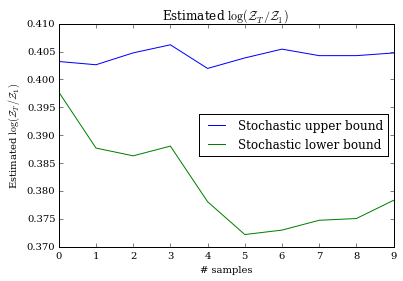

In [42]:
plt.plot(ub,label='Stochastic upper bound')
plt.plot(lb,label='Stochastic lower bound')
plt.xlabel('# samples')
plt.ylabel(r'Estimated $\log ( \mathcal{Z}_T / \mathcal{Z}_1)$')
plt.title(r'Estimated $\log ( \mathcal{Z}_T / \mathcal{Z}_1)$')
plt.legend(loc='best')

Do we know the correct value here?

Question: is any remaining gap here a function of the non-equilibrium work being performed?

In [43]:
ub.mean(),lb.mean()

(0.40412792331083047, 0.38112039860166858)

In [44]:
np.mean((ub[-1],lb[-1]))

0.39153455496222334

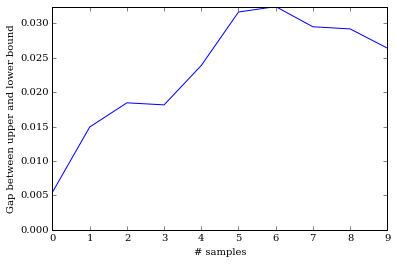

In [46]:
plt.plot(ub-lb)
plt.ylim(0,np.max(ub-lb))
plt.xlabel('# samples')
plt.ylabel('Gap between upper and lower bound')

In [47]:
z_hat_f,xs_f,weights_f,ratios_f=forward_results
z_hat_r,xs_r,weights_r,ratios_r=reverse_results

In [48]:
ratios_f.shape

(10, 15)

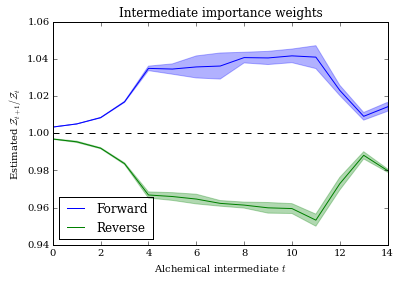

In [49]:
mean_f = ratios_f.mean(0)
err_f = ratios_f.std(0)
plt.plot(mean_f,color='blue',label='Forward');
plt.fill_between(range(len(mean_f)),mean_f-err_f,mean_f+err_f,alpha=0.3,color='blue')
plt.hlines(1.0,0,len(mean_f)-1,linestyle='--')
#plt.figure()
mean_r = ratios_r.mean(0)[::-1]
err_r = ratios_r.std(0)[::-1]
plt.plot(mean_r,color='green',label='Reverse');
plt.fill_between(range(len(mean_r)),mean_r-err_r,mean_r+err_r,alpha=0.3,color='green')
plt.legend(loc='best')
plt.xlabel(r'Alchemical intermediate $t$')
plt.ylabel('Estimated $\mathcal{Z}_{t+1}/\mathcal{Z}_{t}$')
plt.title('Intermediate importance weights')